In [82]:
#%%
import re
from fears.utils.AutoRate import Plate
from fears.utils import plotter
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy.optimize as sciopt
import scipy.stats as stats
import pandas as pd
import scipy

# reminder: col 12 is the background condition

In [83]:
# define helper functions

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def get_plate_paths(folder_path):
    """Gets plate data paths
    Returns:
        list: list of plate data paths
    """
    plate_files = os.listdir(path=folder_path)

    #Need to make sure we are only attempting to load .csv or .xlsx data
    plate_files = [i for i in plate_files]

    plate_files.sort()

    plate_data_paths = []

    for pf in plate_files:
        if pf != '.DS_Store':
            plate_path = folder_path + os.sep + pf
            plate_data_paths.append(plate_path)

    plate_data_paths.sort(key=natural_keys)
    return plate_data_paths

def get_data_file_paths(plate_path):
    files = os.listdir(path=plate_path)

    #Need to make sure we are only attempting to load .csv or .xlsx data
    files = [i for i in files if ('.csv' in i) or ('.xlsx' in i)]

    files.sort()

    file_data_paths = []

    for pf in files:
        if pf != '.DS_Store':
            file_path = plate_path + os.sep + pf
            file_data_paths.append(file_path)

    return file_data_paths

def od_to_cells(od):
    """Background subtracted od to cell count

    Args:
        od (_type_): _description_

    Returns:
        _type_: _description_
    """
    m = 1
    b = 13.52
    res = []
    for o in od:
        if o < 0:
            res.append(0)
        else:
            res.append(np.exp(m*np.log(o) + b))
    return np.array(res)

def int_to_binary(num,n_genotype=16):
    """
    Converts an integer to binary representation with the number of 
    digits equal to the number of alleles in the model.

    Parameters
    ----------
    num : int
        Number to be converted.

    Returns
    -------
    str
        Binary representation.

    """
    pad = int(np.log2(n_genotype))
    return bin(num)[2:].zfill(pad)

In [84]:
# os.chdir('/Users/eshanking/repos/seascapes_figures/')
os.chdir('/Users/kinge2/repos/seascapes_figures/')

In [85]:
# Load data

row_list = ['A','B','C','D','E','F','G','H']
col_list = ['1','2','3','4','5','6','7','8','9','10','11','12']
drug_conc = [10000,2000,400,80,16,3.2,0.64,0.128,0.0256,0.00512,0,'control']
folder_path = 'data/08312022'

plate_paths = get_plate_paths(folder_path)

def get_data_file_paths(plate_path):
    files = os.listdir(path=plate_path)

    #Need to make sure we are only attempting to load .csv or .xlsx data
    files = [i for i in files if ('.csv' in i) or ('.xlsx' in i)]

    files.sort()

    file_data_paths = []

    for pf in files:
        if pf != '.DS_Store':
            file_path = plate_path + os.sep + pf
            file_data_paths.append(file_path)

    return file_data_paths

In [86]:
# background subtraction

bg_col = '12'

count = 0

gr_lib = {}

# list of dicts representing each plate. Keys of the dicts are individual wells
timeseries_dicts = []

for pp in plate_paths:
# for pp in [plate_paths[9]]:

    row = int(np.floor(count/4))
    col = int(np.mod(count,4))

    data_paths0 = get_data_file_paths(pp)

    timeseries_dict = {}
    timeseries_dict['Time'] = []
    logistic_params_dict = {}

    for p in data_paths0:

        plate = Plate(p,mode='single_measurement')
        data = plate.data
        data_dict = plate.od_data_to_dict(data)

        # df = pd.read_excel(p)
        t = plate.get_start_time()

        data_dict['Time'] = t

        # estimate background
        bg_est = 0
        for row in row_list:
            key = row + bg_col
            bg_est += data_dict[key]
        bg_est = bg_est/len(row_list)

        # bg = get_background(data_dict,bg_keys)
        for key in data_dict:
            if key != 'Time':
                if key in timeseries_dict.keys():
                    od = data_dict[key] - bg_est
                    timeseries_dict[key].append(od)
                else:
                    od = data_dict[key] - bg_est
                    timeseries_dict[key] = [od]
                
        timeseries_dict['Time'].append(t)

    # sort out time
    t_vect = timeseries_dict['Time']
    t0 = t_vect[0]
    t_vect = [(t-t0).total_seconds() for t in t_vect]
    timeseries_dict['Time'] = t_vect
    timeseries_dicts.append(timeseries_dict)

In [87]:
def est_linear_slope(counts,
                    dt=1,
                    time=None,
                    window=10,
                    step=1,
                    thresh=0.65,
                    debug=False,
                    title=None,
                    exclude=0,
                    cell_death_thresh=0.5):
        """A non-parametric method for estimating the slope of growth curves

        Args:
            OD (array-like): Raw optical density data
            window (float,optional): Window for rolling linear regression. Defaults to 10.
            step (float, optional): Step size for rolling lienar regression. Defaults to 5.
            thresh (float, optional): Percentage of max slope to include in final 
            linear regression. Defaults to 0.65.
            debug (bool, optional): If True, plots linear fit over data. Defaults to False.

        Returns:
            _type_: _description_
        """

        n_measurements = len(counts)
        if type(counts) is list:
            counts = np.array(counts)

        if time is None:
            time = np.arange(len(counts))

        # remove zero values
        time = np.delete(time,np.argwhere(counts<=0))
        counts = np.delete(counts,np.argwhere(counts<=0))

        if len(counts) < n_measurements/2:
            # print('Counts less than zero')
            return np.nan
        
        lnCount = np.log(counts) # normalize OD data
        # lnCount = lnCount - np.min(lnCount)

        if lnCount[-1] < cell_death_thresh:
            
            return 0

        slopes = []
        x_pos = []

        # calculate piecewise slopes
        for indx in range(exclude,len(lnCount)-window+step,step):
            time_t = time[indx:indx+window]
            subset = lnCount[indx:indx+window]
            fit = scipy.stats.linregress(time_t,subset)
            slopes.append(fit.slope)
            x_pos.append(indx)

        # print(slopes)
        # print(slopes)
        if all(np.array(slopes)<=0):
            # print('All slopes are negative')
            return 0
        # find the max slope
        
        lb = thresh*np.nanmax(slopes)

        use_indices = np.argwhere(slopes>=lb)[:,0]

        if len(use_indices) == 1:
            # print('Only one slope above threshold')
            if debug:
                fig,ax = plt.subplots(figsize=(4,4))
                ax.plot(time,lnCount,linewidth=2,label='lnCount')
                ax.set_title(title)
                
                time_t = time[x_pos[use_indices[0]]:x_pos[use_indices[0]]+window]
                y = lnCount[x_pos[use_indices[0]]:x_pos[use_indices[0]]+window]
                ax.plot(time_t,y,linewidth=2,label='Linear fit')

                ax.legend(frameon=False)

                ax.set_title('Use indices length = 1')
            return np.nanmax(slopes)
        # print(use_indices)
        # print(x_pos)
        if len(use_indices) > 1:
            lin_range = x_pos[np.min(use_indices):np.max(use_indices)+1]

        else:
            lin_range = x_pos[use_indices[0]:use_indices[0]+1]
        # print(lin_range)

        # compute slope and plot result
        time_t = time[lin_range]
        lin_seg = lnCount[lin_range]
        # print(lin_seg)
        fit = scipy.stats.linregress(time_t,lin_seg)
        slope = fit.slope

        count_fit = time_t*fit.slope + fit.intercept

        if np.isnan(slope):
            # raise Warning('Slope is NaN, adjust parameters')
            # print('Slope is NaN, adjust parameters')
            return slope

        rate = slope/dt

        # plot the linear regression
        if debug:
            fig,ax = plt.subplots(figsize=(4,4))
            ax.plot(time,lnCount,linewidth=2,label='lnCount')
            ax.set_title(title)
            
            ax.plot(time_t,count_fit,linewidth=2,label='Linear fit')

            ax.legend(frameon=False)

            ax.set_title(title)

        return rate # per hour

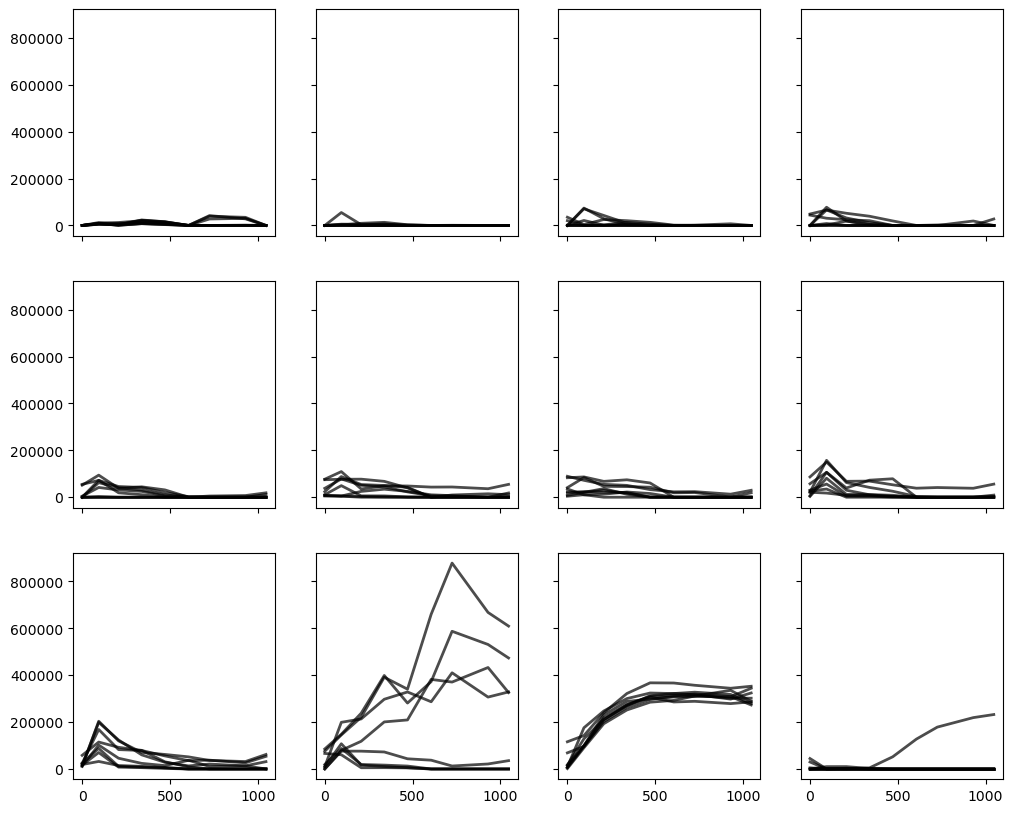

In [88]:
#%% Estimate growth rate
cmap = mpl.cm.get_cmap('viridis')
# fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(15,12))

seascape = {}

# for i in range(len(timeseries_dicts)):
for i in [0]:

    ts_dict = timeseries_dicts[i]
    time = np.array(ts_dict['Time'])/60
    
    gr_v_dc = []
    gr_v_dc_err = []

    fig,ax_list = plt.subplots(nrows=3,ncols=4,figsize=(12,10),sharex=True,sharey=True)
    ax_list = ax_list.flatten()

    for j in range(len(col_list)):
        ax = ax_list[j]
        ts_t = np.zeros((len(ts_dict['Time']),8))
        col = col_list[j]
        rate_list = []
        for k in range(len(row_list)):
            row = row_list[k]
            key = row+col
            if key in ts_dict.keys():
                ts_t[:,k] = ts_dict[key]
                y = ts_t[:,k]
                y = np.array(y)
                y = od_to_cells(y)

                ax.plot(time,y,linewidth=2,color='k',alpha=0.7)
        # ax.set_yscale('log')

    ax = ax_list[0]
    yl = ax.get_ylim()
    # ax.set_ylim(10**4,yl[1])

In [89]:
#%% Estimate growth rate
cmap = mpl.cm.get_cmap('viridis')
# fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(15,12))

seascape = {}
thresh = np.log(10**5)

for i in range(len(timeseries_dicts)):
# fig,ax_list = plt.subplots(nrows=4,ncols=3,figsize=(10,10),sharex=True,sharey=True)
# ax_list = ax_list.flatten()

# for i in [15]:

    ts_dict = timeseries_dicts[i]
    time = np.array(ts_dict['Time'])/60
    
    gr_v_dc = []
    gr_v_dc_err = []

    for j in range(len(col_list)):
        # ax = ax_list[j]
        ts_t = np.zeros((len(ts_dict['Time']),8))
        col = col_list[j]
        rate_list = []
        for k in range(len(row_list)):
            row = row_list[k]
            key = row+col
            if key in ts_dict.keys():
                ts_t[:,k] = ts_dict[key]
                y = ts_t[:,k]
                y = np.array(y)
                y = od_to_cells(y)

                rate_est = est_linear_slope(y,time=time,debug=False,
                                            window=2,thresh=0.6,cell_death_thresh=thresh)
                rate_list.append(rate_est*60)

                # ax.plot(time,y,linewidth=2,color='k',alpha=0.7)

        ts_avg = np.nanmean(ts_t,axis=1)
        ts_err = np.nanstd(ts_t,axis=1)/np.sqrt(8)

        gr_mean = np.nanmean(rate_list)
        gr_err = np.nanstd(rate_list)/np.sqrt(8)

        gr_v_dc.append(gr_mean)
        gr_v_dc_err.append(gr_err)
        # ax.set_title(np.round(gr_err,5)*100)

        

    
    seascape_t = {'gr_avg':gr_v_dc,'gr_err':gr_v_dc_err}
    seascape[i] = seascape_t


# fig.tight_layout()

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_2455/325554504.py:69: RuntimeWarning: divide by zero encountered in log
  res.append(np.exp(m*np.log(o) + b))


In [90]:
gr_lib = pd.DataFrame(columns=np.arange(16),index=np.arange(len(drug_conc)))
gr_err_lib = pd.DataFrame(columns=np.arange(16),index=np.arange(len(drug_conc)))

for key in seascape:
    seascape_t = seascape[key]
    for i in gr_lib.index:
        gr_lib.loc[i,key] = seascape_t['gr_avg'][i]
        gr_err_lib.loc[i,key] = seascape_t['gr_err'][i]
gr_lib['drug_conc'] = drug_conc
gr_err_lib['drug_conc'] = drug_conc

gr_lib.to_csv('results/gr_lib.csv')
gr_err_lib.to_csv('results/gr_err_lib.csv')

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_2455/2075767550.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


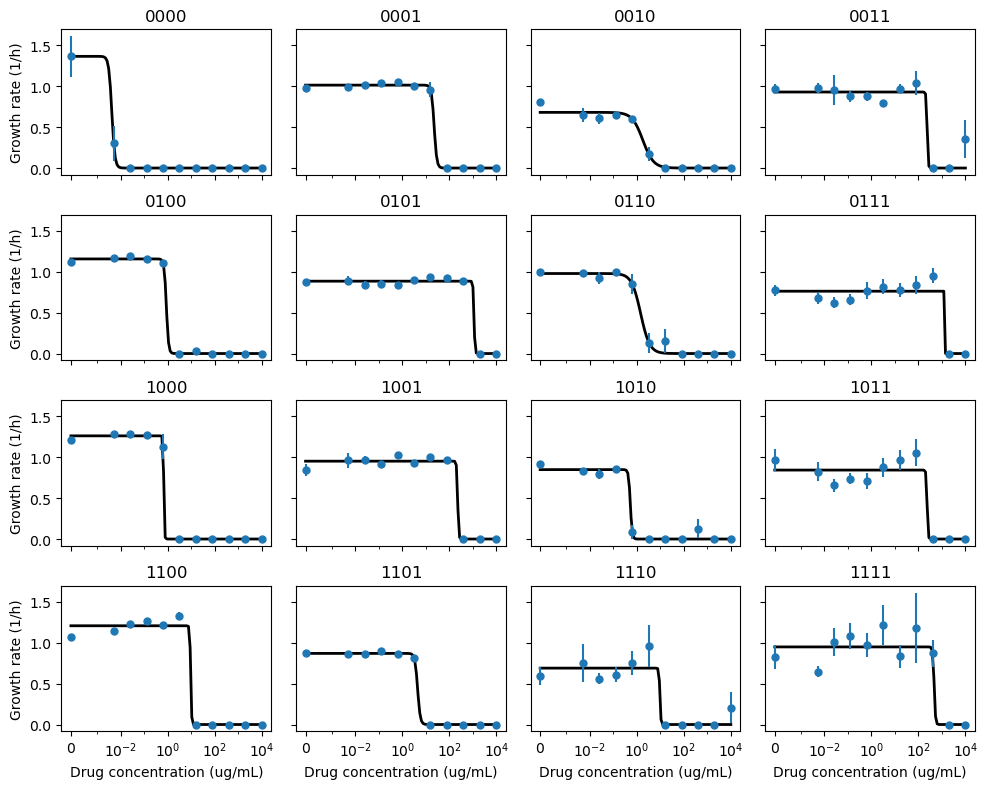

In [91]:
def hill_fn(conc,gmax, hc, ic_50):
    y = []
    gmin = 0
    for c in conc:
        if c == 0:
            y.append(gmax)
        else:
            y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))
    return y

fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(10,8),sharex=True,sharey=True)
ax_list_matrix = ax_list
ax_list = ax_list.flatten()

g_drugless = np.zeros(16)

mic_est = []

seascape_lib = {}


for key in seascape.keys():
    y = np.array(seascape[key]['gr_avg'])
    y = y[0:-1]
    x = np.argwhere(y<0.5)
    mic = drug_conc[x[-1][0]]
    mic_est.append(mic)

for i in range(16):
    seascape_t = seascape[i]
    gr_v_dc = seascape_t['gr_avg']
    gr_v_dc_err = seascape_t['gr_err']

    ic50_est = np.log10(mic_est[i])

    p0 = [gr_v_dc[-2],-0.1,ic50_est]
    # bounds = [[gr_v_dc[-2]-0.1,-10,ic50_est-2],[gr_v_dc[-2]+0.1,0,ic50_est+2]]
    bounds = [[0,-10,ic50_est-2],[2,0,ic50_est+2]]

    gr_v_dc_err_t = np.array(gr_v_dc_err) + 1

    popt,pcov = sciopt.curve_fit(hill_fn,drug_conc[0:-1],gr_v_dc[0:-1],
                                p0=p0,maxfev=100000,bounds=bounds,
                                sigma=gr_v_dc_err_t[0:-1],absolute_sigma=False)
    
    xfit = np.logspace(-3,4,100)
    xfit = np.concatenate(([0],xfit))

    yfit = hill_fn(xfit,*popt)

    ax = ax_list[i]
    ax.plot(xfit,yfit,color='k',linewidth=2)

    ax.errorbar(drug_conc[0:-1],gr_v_dc[0:-1],yerr=gr_v_dc_err[0:-1],
                fmt='o',markersize=5)
    
    ax.set_xscale('symlog',linthresh=10**-3)
    ax.set_title(int_to_binary(i))
    # ax.set_yscale('log')
    g_drugless[i] = gr_v_dc[-2]

    param_dict = {'gmax':popt[0],'hc':popt[1],'ic50':popt[2]}
    seascape_lib[i] = param_dict

ax = ax_list[-1]
ax.set_xticks([0,10**-2,1,10**2,10**4]);

for ax in ax_list_matrix[-1,:]:
    ax.set_xlabel('Drug concentration (ug/mL)')

for ax in ax_list_matrix[:,0]:
    ax.set_ylabel('Growth rate (1/h)')

fig.tight_layout()

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_2455/2075767550.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


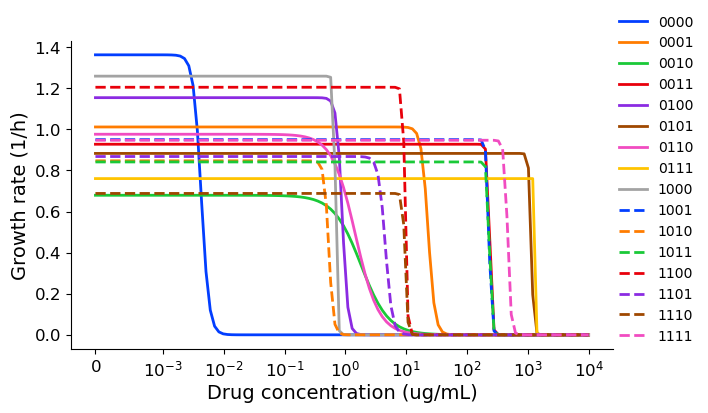

In [92]:
# plot all pharmacodynamic curves

fig,ax = plt.subplots(figsize=(7,4))

conc = np.logspace(-3,4,100)
conc = np.concatenate(([0],conc))

cc = plotter.gen_color_cycler()
ax.set_prop_cycle(cc)

for key in seascape_lib.keys():
    param_dict = seascape_lib[key]
    gmax = param_dict['gmax']
    hc = param_dict['hc']
    ic50 = param_dict['ic50']

    y = hill_fn(conc,gmax,hc,ic50)
    ax.plot(conc,y,linewidth=2,label=int_to_binary(key))

ax.set_xscale('symlog',linthresh=10**-3)

ax.set_xlabel('Drug concentration (ug/mL)',fontsize=14)
ax.set_ylabel('Growth rate (1/h)',fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both',labelsize=12)

ax.legend(frameon=False,fontsize=10,ncol=1,loc=(1,0))

In [93]:
int_to_binary(4)

'0100'

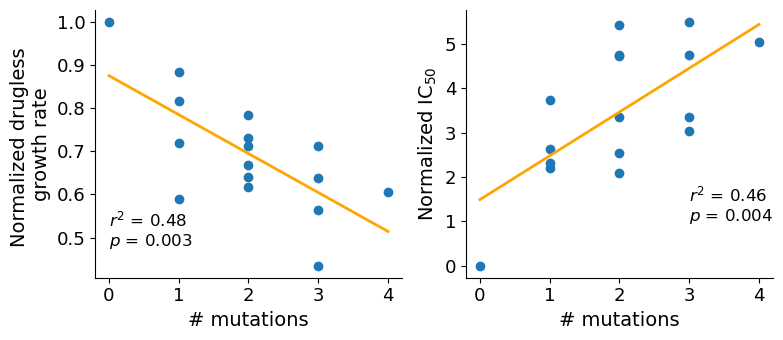

In [94]:
mut_list = []

for key in seascape.keys():

    # key_bin = int(key)

    key_bin = int_to_binary(int(key))

    num = 0
    for s in key_bin:
        num+=int(s)

    mut_list.append(num)

fig,ax_list = plt.subplots(ncols=2,figsize=(8,3.5))

g_drugless = np.array(g_drugless)
g_norm = g_drugless/g_drugless[0]

ax = ax_list[0]

ax.plot(mut_list,g_norm,'o')

res = stats.linregress(mut_list,g_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='orange',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=14)
ax.set_ylabel('Normalized drugless \ngrowth rate',fontsize=14)
ax.tick_params(axis='both', labelsize=13)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.48),fontsize=12)

ax = ax_list[1]

ic50_est = []

for key in seascape_lib.keys():
    ic50_est.append(seascape_lib[key]['ic50'])

ic50_norm = ic50_est - ic50_est[0]

ax.plot(mut_list,ic50_norm,'o')

res = stats.linregress(mut_list,ic50_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='orange',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=14)
ax.set_ylabel('Normalized IC$_{50}$',fontsize=14)
ax.tick_params(axis='both', labelsize=13)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(3,1),fontsize=12)

fig.tight_layout()

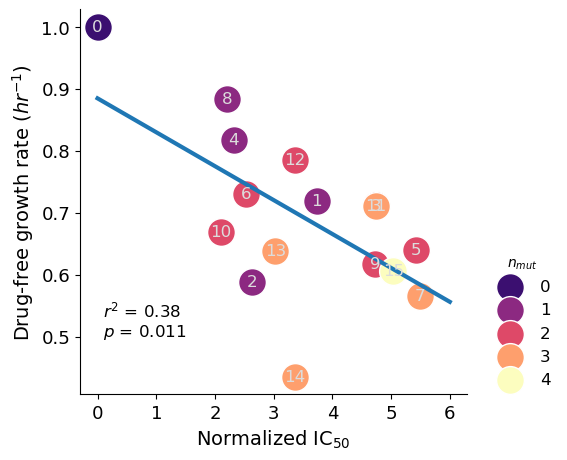

In [95]:
# mic_est = []

# for key in seascape.keys():
#     y = np.array(seascape[key]['gr_avg'])
#     y = y[0:-1]
#     x = np.argwhere(y<0.5)
#     mic = drug_conc[x[-1][0]]
#     mic_est.append(mic)

# mic_est = np.log10(mic_est)

# mic_norm = mic_est - min(mic_est)

fig,ax = plt.subplots(figsize=(5,5))

gr_list = []

cmap = cm.get_cmap('magma',6)
cmap = cmap.colors

mut_v_gr = [[],[],[],[],[]]

mut_list = []

ic50_norm = ic50_est - ic50_est[0]

for key in seascape_lib.keys():

    ic50 = ic50_norm[int(key)]
    g = g_norm[int(key)]

    # key_bin = int(key)

    key_bin = int_to_binary(int(key))

    num = 0
    for s in key_bin:
        num+=int(s)

    mut_list.append(num)

    mut_v_gr[num].append(g_drugless)

    ax.scatter(ic50,g,marker='o',s=400,facecolor=cmap[num+1],
                edgecolors='w',label=int(num))
    # ax4.annotate(key,(ic50-0.15,g_drugless-0.001),fontsize=12)
    ax.annotate(key,(ic50,g),fontsize=12,ha='center',va='center',color='gainsboro')
    

# ax.set_ylim(0.06,0.115)
# ax.set_xlim(-3,4)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=14)
ax.set_xlabel('Normalized IC$_{50}$',fontsize=14)
ax.tick_params(axis='both', labelsize=13)

handles, labels = ax.get_legend_handles_labels()

unique_labels = sorted(set(labels))
labels = np.array(labels)
unique_handles = []

for lab in unique_labels:
    indx = np.argwhere(labels==lab)
    indx = indx[0][0]
    unique_handles.append(handles[indx])

ax.legend(unique_handles,unique_labels,loc = (1.05,0),frameon=False,
             fontsize=12,title='$n_{mut}$')

res = stats.linregress(ic50_norm,g_norm)

xfit = np.arange(0,7)
yfit = res.slope*xfit + res.intercept

ax.plot(xfit,yfit,color='tab:blue',linewidth=3)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0.1,0.5),fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [101]:
# estimate MIC from pharmacodynamic curves

mic_est = []

# for key in seascape.keys():
#     gr = np.array(seascape[key]['gr_avg'][0:-1])
#     conc = np.array(drug_conc[0:-1])
#     indx = np.argwhere(gr>0)[0][0]
#     mic = conc[indx-1]
#     mic_est.append(mic)

# print(mic_est)

thresh = 0.001 # fraction of maximum considered to be inhibtory

conc = np.logspace(-3,5,1000)

seascape_lib_save = {}

for key in seascape_lib.keys():
    param_dict = seascape_lib[key]
    gmax = param_dict['gmax']
    hc = param_dict['hc']
    ic50 = param_dict['ic50']

    y = hill_fn(conc,gmax,hc,ic50)

    x = np.argwhere(y<(gmax*thresh))
    
    indx = x[0][0]
    mic = conc[indx]
    mic_est.append(mic)

    dict_t = {'g_drugless':gmax,'gmax':gmax,'hc':hc,'ic50':ic50,'mic':mic}
    seascape_lib_save[key] = dict_t

print(mic_est)

df = pd.DataFrame(seascape_lib_save)
df.to_csv('results/seascape_lib_09252023.csv')


[0.011832406274583786, 56.07234882852027, 67.42622241778335, 323.2283978181381, 1.8504070195423021, 1549.4950393146316, 31.080821738690638, 1336.9837418249451, 0.8850074914473438, 323.2283978181381, 0.9704808877380307, 323.2283978181381, 13.0652016212472, 11.067360180959746, 13.30834724654076, 727.5483529196233]


/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_2455/2075767550.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


In [100]:
param_dict

{'gmax': 0.9470095679460548,
 'hc': -0.02726065461713192,
 'ic50': 2.6687775892445407}

In [97]:
df = pd.DataFrame({'g_drugless':g_drugless,'ic50':ic50_est,'n_mut':mut_list})
df.to_csv('results/dose_response_params_09252023.csv')